This notebook reports how many hours members spent off the board and whether there is missing data.


In [1]:
from __future__ import absolute_import, division, print_function
from multiprocessing import Pool

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Config and load

In [2]:
import sys
sys.path.insert(0, '../../src/data/')

from config import *

In [3]:
#Preparing the members and beacons metadata
members_metadata = pd.read_csv(members_metadata_path).set_index('member')
beacons_metadata = pd.read_csv(beacons_metadata_path).set_index('beacon')

In [4]:
members_metadata.head()

,company,member_id,start_date,end_date,participates,RecipientID
member,,,,,,
1BFLH7NZGE,Company B,535,2018-06-12 00:00:00,2018-08-15 23:59:59,1,MLRP_0vcgVNdOY7vpB7D
WLA510JNBN,Company B,537,2018-06-19 00:00:00,2018-08-15 23:59:59,1,MLRP_74oJw6drZeVi02V
76B60URM93,Company B,730,2018-06-18 00:00:00,2018-07-15 23:59:59,1,MLRP_8Cx2w4pmTcBCFUx
P95P5A6IP2,Company B,536,2018-06-13 00:00:00,2018-08-15 23:59:59,1,MLRP_5j3Rlvkq0RYG7s1
MKC03RM7T5,Company N,541,2018-06-12 00:00:00,2018-07-15 23:59:59,1,MLRP_38gd2aldS3XcP89


In [5]:
# load only participating members
members_metadata = members_metadata[members_metadata['participates'] == 1]

In [6]:
bin_size = 15 #minutes

In [7]:
data_store_path = clean_store_path
#data_store_path = dirty_store_path

In [8]:
period1_start_ts = pd.Timestamp('2018-06-19 00:00:00', tz=time_zone)
period1_end_ts = pd.Timestamp('2018-06-19 23:00:00', tz=time_zone)

# Calculate on/off board

Helper functions for filtering the data:

In [9]:
def get_closest_beacon(m5cb, members_metadata, beacons_metadata):
    """
    Parameters: dataframe, dataframe, dataframe
    Returns: a table with the closest beacon for each member
    """
    
    #Create table with only closest beacon
    m1cb = m5cb[['beacon_0', 'rssi_0']].rename(
        columns = {'beacon_0': 'beacon', 'rssi_0': 'rssi'}).reset_index()

    #Add beacon metadata
    m1cb = m1cb.join(
            beacons_metadata[['company', 'type']], on='beacon').rename(
            columns = {'company': 'beacon_company', 'type': 'beacon_type'})
    
    #Add badge metadata
    #m1cb = m1cb.join(
    #        members_metadata[['company']], on='member').rename(columns = {'company': 'member_company'})
    
    return m1cb

In [10]:
def on_board(mySeries):
    """
    Given a dataframe
    Returns an additional column of booleans
        True if beacon type is board
        False otherwise
    """
    return mySeries['beacon_type'] == 'board'

In [11]:
# Converts record counts to number of minutes. Each records represents a 15 seconds interval in this experiment
def count_to_minutes_for_row(row):
    """
    Given a count
    Returns minutes
    """
    if False in row and not np.isnan(row[False]):
        counter = row[False]
        seconds = counter*15
        minutes = seconds/60
        return(round(minutes,2))
    
    if True in row and not np.isnan(row[True]):
        return 0 # has data, but all data is on the board
    
    #else (both nan or neither exists)
    return np.NaN;
        
    
def count_to_minutes(counter):
    """
    Given a count
    Returns minutes
    """
    seconds = counter*15
    minutes = seconds/60
    return(round(minutes,2))


In [12]:
# Generating a talbe with bin_size intervals for teh period of interest
period1_dates = pd.date_range(start=period1_start_ts, end=period1_end_ts, freq=str(bin_size)+'min', name='start').to_series(
    keep_tz=True)

In [19]:
# Converts a given timestamp to date string
def ts_to_string(ts,fmt='%m-%d %R'):
    return ts.strftime(fmt)

# Calculate
First, prepare an emtpy dataframe with a row for each member. then, create a columns for each interval and populate minutes count for each member.

Note - we use a condition in read_hdf to read data for one interval at each iteration to reduce the memory footprint.

In [21]:
# Prepares an emtpy dataframe with a row for each member
minutes_off_board_period_one = pd.DataFrame(index = members_metadata.reset_index()['member'])

# Interate over all intervals
for i in range(0, len(period1_dates) - 1, 1):
    start_ts = period1_dates[i]
    end_ts = period1_dates[i+1]
    print("Calculating period: {} - {}".format(start_ts,end_ts))
    tempMinutes = pd.DataFrame()
    tempMinutesTotal = pd.DataFrame()
    
    where = "datetime >= '" + str(start_ts) + "' & datetime < '" + str(end_ts) + "'"
    
    m5cb = pd.read_hdf(data_store_path,'proximity/member_5_closest_beacons', where = where, data_columns= True) 
    m1cb_with_boards = get_closest_beacon(m5cb, members_metadata, beacons_metadata)
    m1cb_with_boards['on_board'] = on_board(m1cb_with_boards)
    
    grouped_with_boards = m1cb_with_boards.groupby(['member', 'on_board'])

    counts_with_boards = grouped_with_boards['on_board'].count()
    counts_with_boards = counts_with_boards.unstack()
    #counts_with_boards.columns = counts_with_boards.columns.droplevel(0)

    ts_str = ts_to_string(start_ts)
    
    # Minutes off the board (=compliance)
    if (len(counts_with_boards) >0):
        tempMinutes[ts_str] = counts_with_boards.apply(count_to_minutes_for_row, axis=1)
    else:
        tempMinutes[ts_str] = np.NaN
    minutes_off_board_period_one = minutes_off_board_period_one.join(tempMinutes)    
    


Calculating period: 2018-06-19 00:00:00-04:00 - 2018-06-19 00:15:00-04:00
Calculating period: 2018-06-19 00:15:00-04:00 - 2018-06-19 00:30:00-04:00
Calculating period: 2018-06-19 00:30:00-04:00 - 2018-06-19 00:45:00-04:00
Calculating period: 2018-06-19 00:45:00-04:00 - 2018-06-19 01:00:00-04:00
Calculating period: 2018-06-19 01:00:00-04:00 - 2018-06-19 01:15:00-04:00
Calculating period: 2018-06-19 01:15:00-04:00 - 2018-06-19 01:30:00-04:00
Calculating period: 2018-06-19 01:30:00-04:00 - 2018-06-19 01:45:00-04:00
Calculating period: 2018-06-19 01:45:00-04:00 - 2018-06-19 02:00:00-04:00
Calculating period: 2018-06-19 02:00:00-04:00 - 2018-06-19 02:15:00-04:00
Calculating period: 2018-06-19 02:15:00-04:00 - 2018-06-19 02:30:00-04:00
Calculating period: 2018-06-19 02:30:00-04:00 - 2018-06-19 02:45:00-04:00
Calculating period: 2018-06-19 02:45:00-04:00 - 2018-06-19 03:00:00-04:00
Calculating period: 2018-06-19 03:00:00-04:00 - 2018-06-19 03:15:00-04:00
Calculating period: 2018-06-19 03:15:0

# Heatmap
Creates a heatmap that shows the number of minutes off the board (badge is in use). When no data is available, color the interval in red.

In [22]:
heatmap_data = minutes_off_board_period_one.copy()
heatmap_data = heatmap_data.fillna(-1*bin_size) # replace nan with -1*bin_size to indicate missing data
heatmap_data.sort_index(inplace = True)

In [23]:
heatmap_data.head()

,06-19 00:00,06-19 00:15,06-19 00:30,06-19 00:45,06-19 01:00,06-19 01:15,06-19 01:30,06-19 01:45,06-19 02:00,06-19 02:15,...,06-19 20:30,06-19 20:45,06-19 21:00,06-19 21:15,06-19 21:30,06-19 21:45,06-19 22:00,06-19 22:15,06-19 22:30,06-19 22:45
member,,,,,,,,,,,,,,,,,,,,,
02NN8UNDIW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-15.0,-15.0,-15.0,-15.0,-15.0,-15.0,-15.0,-15.0,-15.0,-15.0
08U6OQ5UQH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0QOCAUAVFI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19FB3AOLEI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1BFLH7NZGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


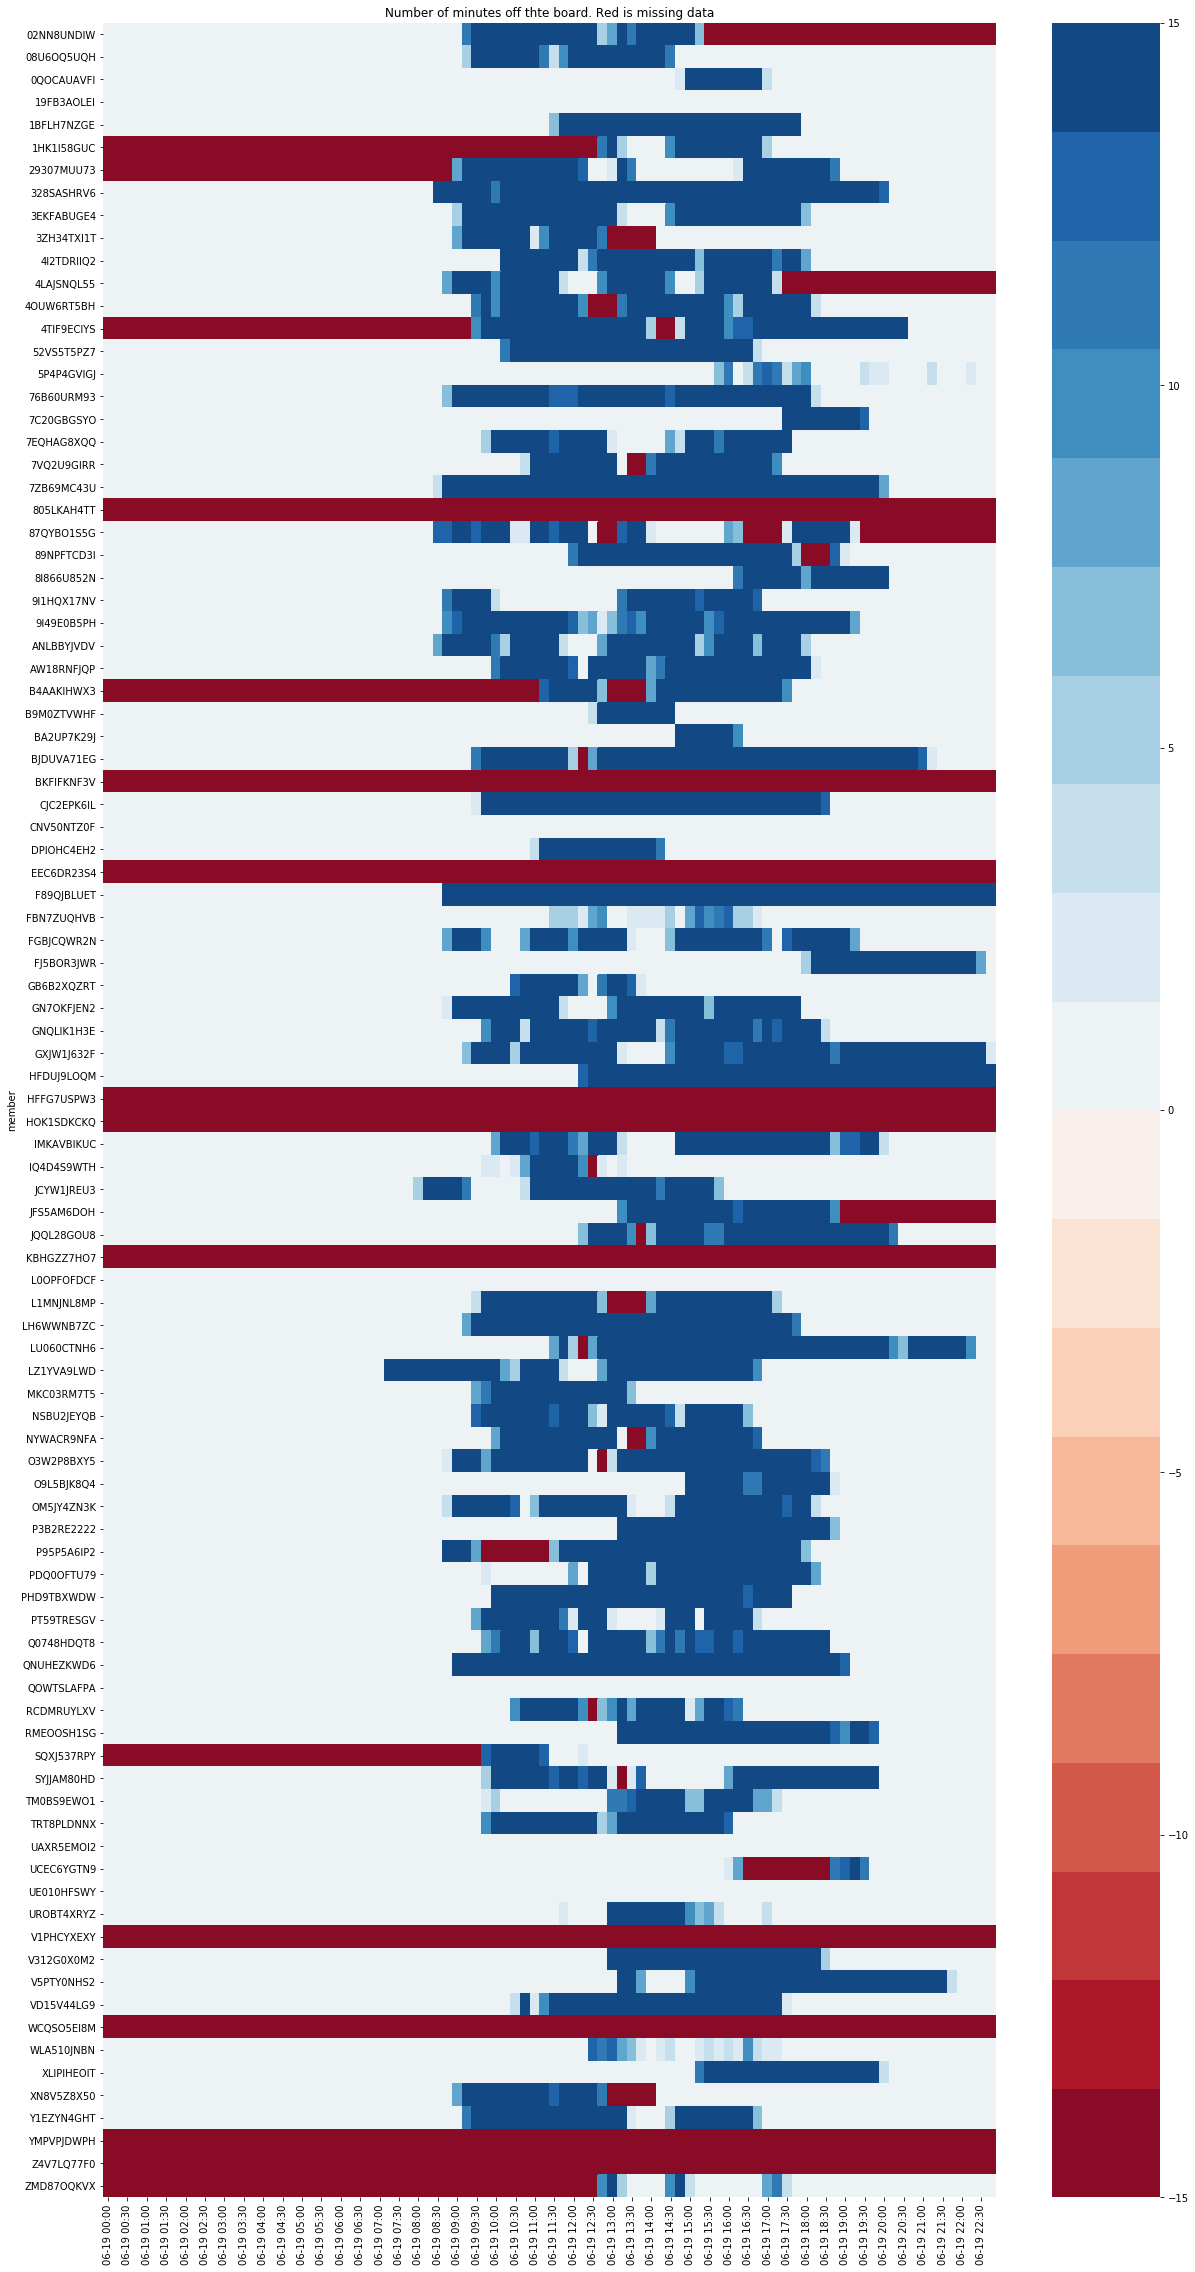

In [25]:
#Creating Period One Heatmap
plt.figure(figsize=(20,40))
sns_plot = sns.heatmap(heatmap_data,cmap=sns.color_palette("RdBu", 20), vmax = 15, 
            cbar = True)
plt.xticks(rotation = 90)
plt.title('Number of minutes off thte board. Red is missing data')
plt.show()

In [19]:
#fig = sns_plot.get_figure()
#fig.savefig(fig_filename)